In [1]:
#HRRR on Python Documentation (Univ. Utah//Brian Blaylock):
#https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/python_data_loading.html
#https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_variables.html
#https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_HRRR/HRRR_Pando.py
#https://blaylockbk.github.io/Web-Homepage/
#https://mesowest.utah.edu/html/hrrr/

#HRRR Info from NOAA
#https://rapidrefresh.noaa.gov/hrrr/
#https://www.nco.ncep.noaa.gov/pmb/products/hrrr/
#https://www.nco.ncep.noaa.gov/pmb/products/hrrr/hrrr.t00z.wrfsfcf00.grib2.shtml

#Main Journal Article for the HRRR:
#https://journals.ametsoc.org/view/journals/mwre/144/4/mwr-d-15-0242.1.xml?tab_body=fulltext-display

#AWS Directories for 5/22
#https://noaa-hrrr-bdp-pds.s3.amazonaws.com/index.html#hrrr.20190523/conus/
#https://hrrrzarr.s3.amazonaws.com/index.html#prs/20190522/20190522_23z_anl.zarr/

In [1]:
import os.path
import os
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ctables
import matplotlib.colors as colors

from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import numpy as np
import numpy.ma as ma
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,semiminor_axis=6371229))

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import scipy.ndimage as ndimage
import scipy.signal as signal

import metpy
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dewpoint_from_relative_humidity, dry_lapse, moist_lapse,
                        vapor_pressure, saturation_vapor_pressure, wind_speed, wind_direction, pressure_to_height_std,
                        mixing_ratio, cape_cin, wind_components, height_to_pressure_std, equivalent_potential_temperature,
                        parcel_profile, precipitable_water, storm_relative_helicity, mean_pressure_weighted, 
                        most_unstable_cape_cin, most_unstable_parcel, supercell_composite, significant_tornado, get_layer,
                        relative_humidity_from_dewpoint, surface_based_cape_cin, mixed_layer_cape_cin,
                        surface_based_cape_cin, potential_temperature, wind_direction, add_pressure_to_height,
                        add_height_to_pressure, divergence, vorticity, lat_lon_grid_deltas, mixed_parcel,
                        most_unstable_parcel, lcl, lfc, mixing_ratio_from_relative_humidity, el,  cape_cin,
                        height_to_pressure_std, dewpoint_from_relative_humidity, dewpoint_from_specific_humidity)
from metpy.units import units
from metpy.plots import SkewT, Hodograph
from metpy.interpolate import interpolate_1d as metinterp, log_interpolate_1d
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.plots.declarative import BarbPlot, ContourPlot, FilledContourPlot, MapPanel, PanelContainer, PlotObs

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv
import pandas as pd
import xarray as xr
import seaborn as sns
from scipy import stats
import s3fs
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.ma import masked_array

import dataclasses
import datetime

D:\Anaconda3\envs\THESIS\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import cmweather

In [3]:
# HRRR Options (I use 'hybrid' in this script):
#a=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'hybrid'})
#b=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'})
#c=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'atmosphere'}) #COMPOSITE REFLECTIVITY
#d=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'cloudTop'})
#e=xr.open_dataset(fname,filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'surface'}) #also 'stepType': 'accum', 'typeOfLevel': 'surface'
#f=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'heightAboveGround'}) #DERIVED REFLECTIIVTY
#g=xr.open_dataset(fname,filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'isothermal'}) #''stepType': 'instant' or 'max'
#           #DERIVED REFLECTIVITY
#h=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'})
#i=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'sigmaLayer'}) #Geometric Vertical Velocity only
#j=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'meanSea'})  #MSLP Only
#k=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'isobaricInhPa'}) #geopotential height only
#l=xr.open_dataset(fname,filter_by_keys={'stepType': 'max','typeOfLevel': 'heightAboveGroundLayer'}) #step types: max, min, instant
#m=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'sigma'}) #hail only
#n=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'})
#o=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'depthBelowLand'})
#p=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'isobaricLayer'})
#q=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'lowCloudLayer'})
#r=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'middleCloudLayer'})
#s=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'highCloudLayer'})
#t=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'cloudBase'})
#u=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'cloudCeiling'})
#v=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'nominalTop'})
#w=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'isothermZero'}) #height/RH.pressure
#x=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'highestTroposphericFreezing'})
#y=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'adiabaticCondensation'})
#z=xr.open_dataset(fname,filter_by_keys={'typeOfLevel': 'equilibrium'})

In [3]:
@dataclasses.dataclass
class ZarrId:
    run_hour: datetime.datetime
    level_type: str
    var_level: str
    var_name: str
    model_type: str
        
    def format_chunk_id(self, chunk_id):
        if self.model_type == "fcst": 
            # Extra id part since forecasts have an additional (time) dimension
            return "0." + str(chunk_id)
        else:
            return chunk_id
        
#CHUNKS FOR 5/22: 2.5, 2.6, 3.5, 3.6

fs = s3fs.S3FileSystem(anon=True) 

def load(url, run_hour=None, new_time_dimension=None):
    # Download the data from S3. May be lazy.
    ds = xr.open_dataset(s3fs.S3Map(url, s3=fs), engine="zarr")
    
    # Add the model run hour in as a dimension
    if run_hour is not None:
        ds[new_time_dimension] = run_hour
        ds = ds.set_coords(new_time_dimension)
    
    # Later on we use metpy functions that expect the grid variables to be x and y
    ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
    return ds

def load_combined_dataset(zarr_ids):
    
    # Get the grid data (at a long forecast hour in case the whole time dim is needed)
    grid_zarr_id = dataclasses.replace(zarr_ids[0]) # dataclasses.replace is just a fancy copy function
    grid_zarr_id.run_hour = grid_zarr_id.run_hour.replace(hour=0)  
    grid = load(create_s3_group_url(grid_zarr_id))
    
    is_forecast = zarr_ids[0].model_type == "fcst"
    new_time_dimension = "reference_time" if is_forecast else "time"
    
    datasets = [load(create_s3_subgroup_url(zarr_id), zarr_id.run_hour, new_time_dimension) 
                for zarr_id in zarr_ids]
    
    if is_forecast: # Align the time axes of each dataset (b/c forecasts have different lengths)
        for dataset in datasets:
            dataset["time"] = grid["time"][:len(dataset["time"])]
        datasets = xr.align(*datasets, join="outer")
        
    ds = xr.concat(datasets, dim=new_time_dimension, combine_attrs="override")
    
    # Add the geospatial data to the combined dataset
    ds["x"] = grid["x"]
    ds["y"] = grid["y"]  
    ds = ds.metpy.assign_crs(projection.to_cf())
    ds = ds.metpy.assign_latitude_longitude()
    
    return ds

def create_s3_group_url(zarr_id, prefix=True):
    url = "s3://hrrrzarr/" if prefix else "" # Skip when using boto3
    url += zarr_id.run_hour.strftime(
        f"{zarr_id.level_type}/%Y%m%d/%Y%m%d_%Hz_{zarr_id.model_type}.zarr/")
    url += f"{zarr_id.var_level}/{zarr_id.var_name}"
    return url

def create_s3_subgroup_url(zarr_id, prefix=True):
    url = create_s3_group_url(zarr_id, prefix)
    url += f"/{zarr_id.var_level}"
    return url

def create_s3_chunk_url(zarr_id, chunk_id, prefix=False):
    url = create_s3_subgroup_url(zarr_id, prefix)
    url += f"/{zarr_id.var_name}/{zarr_id.format_chunk_id(chunk_id)}"
    return url

In [4]:
def radar_colormap():
    nws_reflectivity_colors = [
    "#646464", # ND
    "#ccffff", # -30
    "#cc99cc", # -25
    "#996699", # -20
    "#663366", # -15
    "#cccc99", # -10
    "#999966", # -5
    "#646464", # 0
    "#04e9e7", # 5
    "#019ff4", # 10
    "#0300f4", # 15
    "#02fd02", # 20
    "#01c501", # 25
    "#008e00", # 30
    "#fdf802", # 35
    "#e5bc00", # 40
    "#fd9500", # 45
    "#fd0000", # 50
    "#d40000", # 55
    "#bc0000", # 60
    "#f800fd", # 65
    "#9854c6", # 70
    "#fdfdfd" # 75
    ]
    return matplotlib.colors.ListedColormap(nws_reflectivity_colors)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Main Plotting Script

hrrr.t22z.wrfnatf00.grib2 



C:\Users\kyled\AppData\Local\Temp\ipykernel_19608\3506451148.py:63: UserWarning: Relative humidity >120%, ensure proper units.
  Td=dewpoint_from_specific_humidity(lev* units('hPa'),T* units('kelvin'),q)
D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1396: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1397: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)
D:\Anaconda3\envs\THESIS\lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\kyled\AppData\Local\Temp\ipykernel_19608\3506451148.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP1non = soundings[soundings.Time==Hour][soundings.Grouping=="OPW1"][soundings.Supercell=='N']
C:\Users\kyled\A

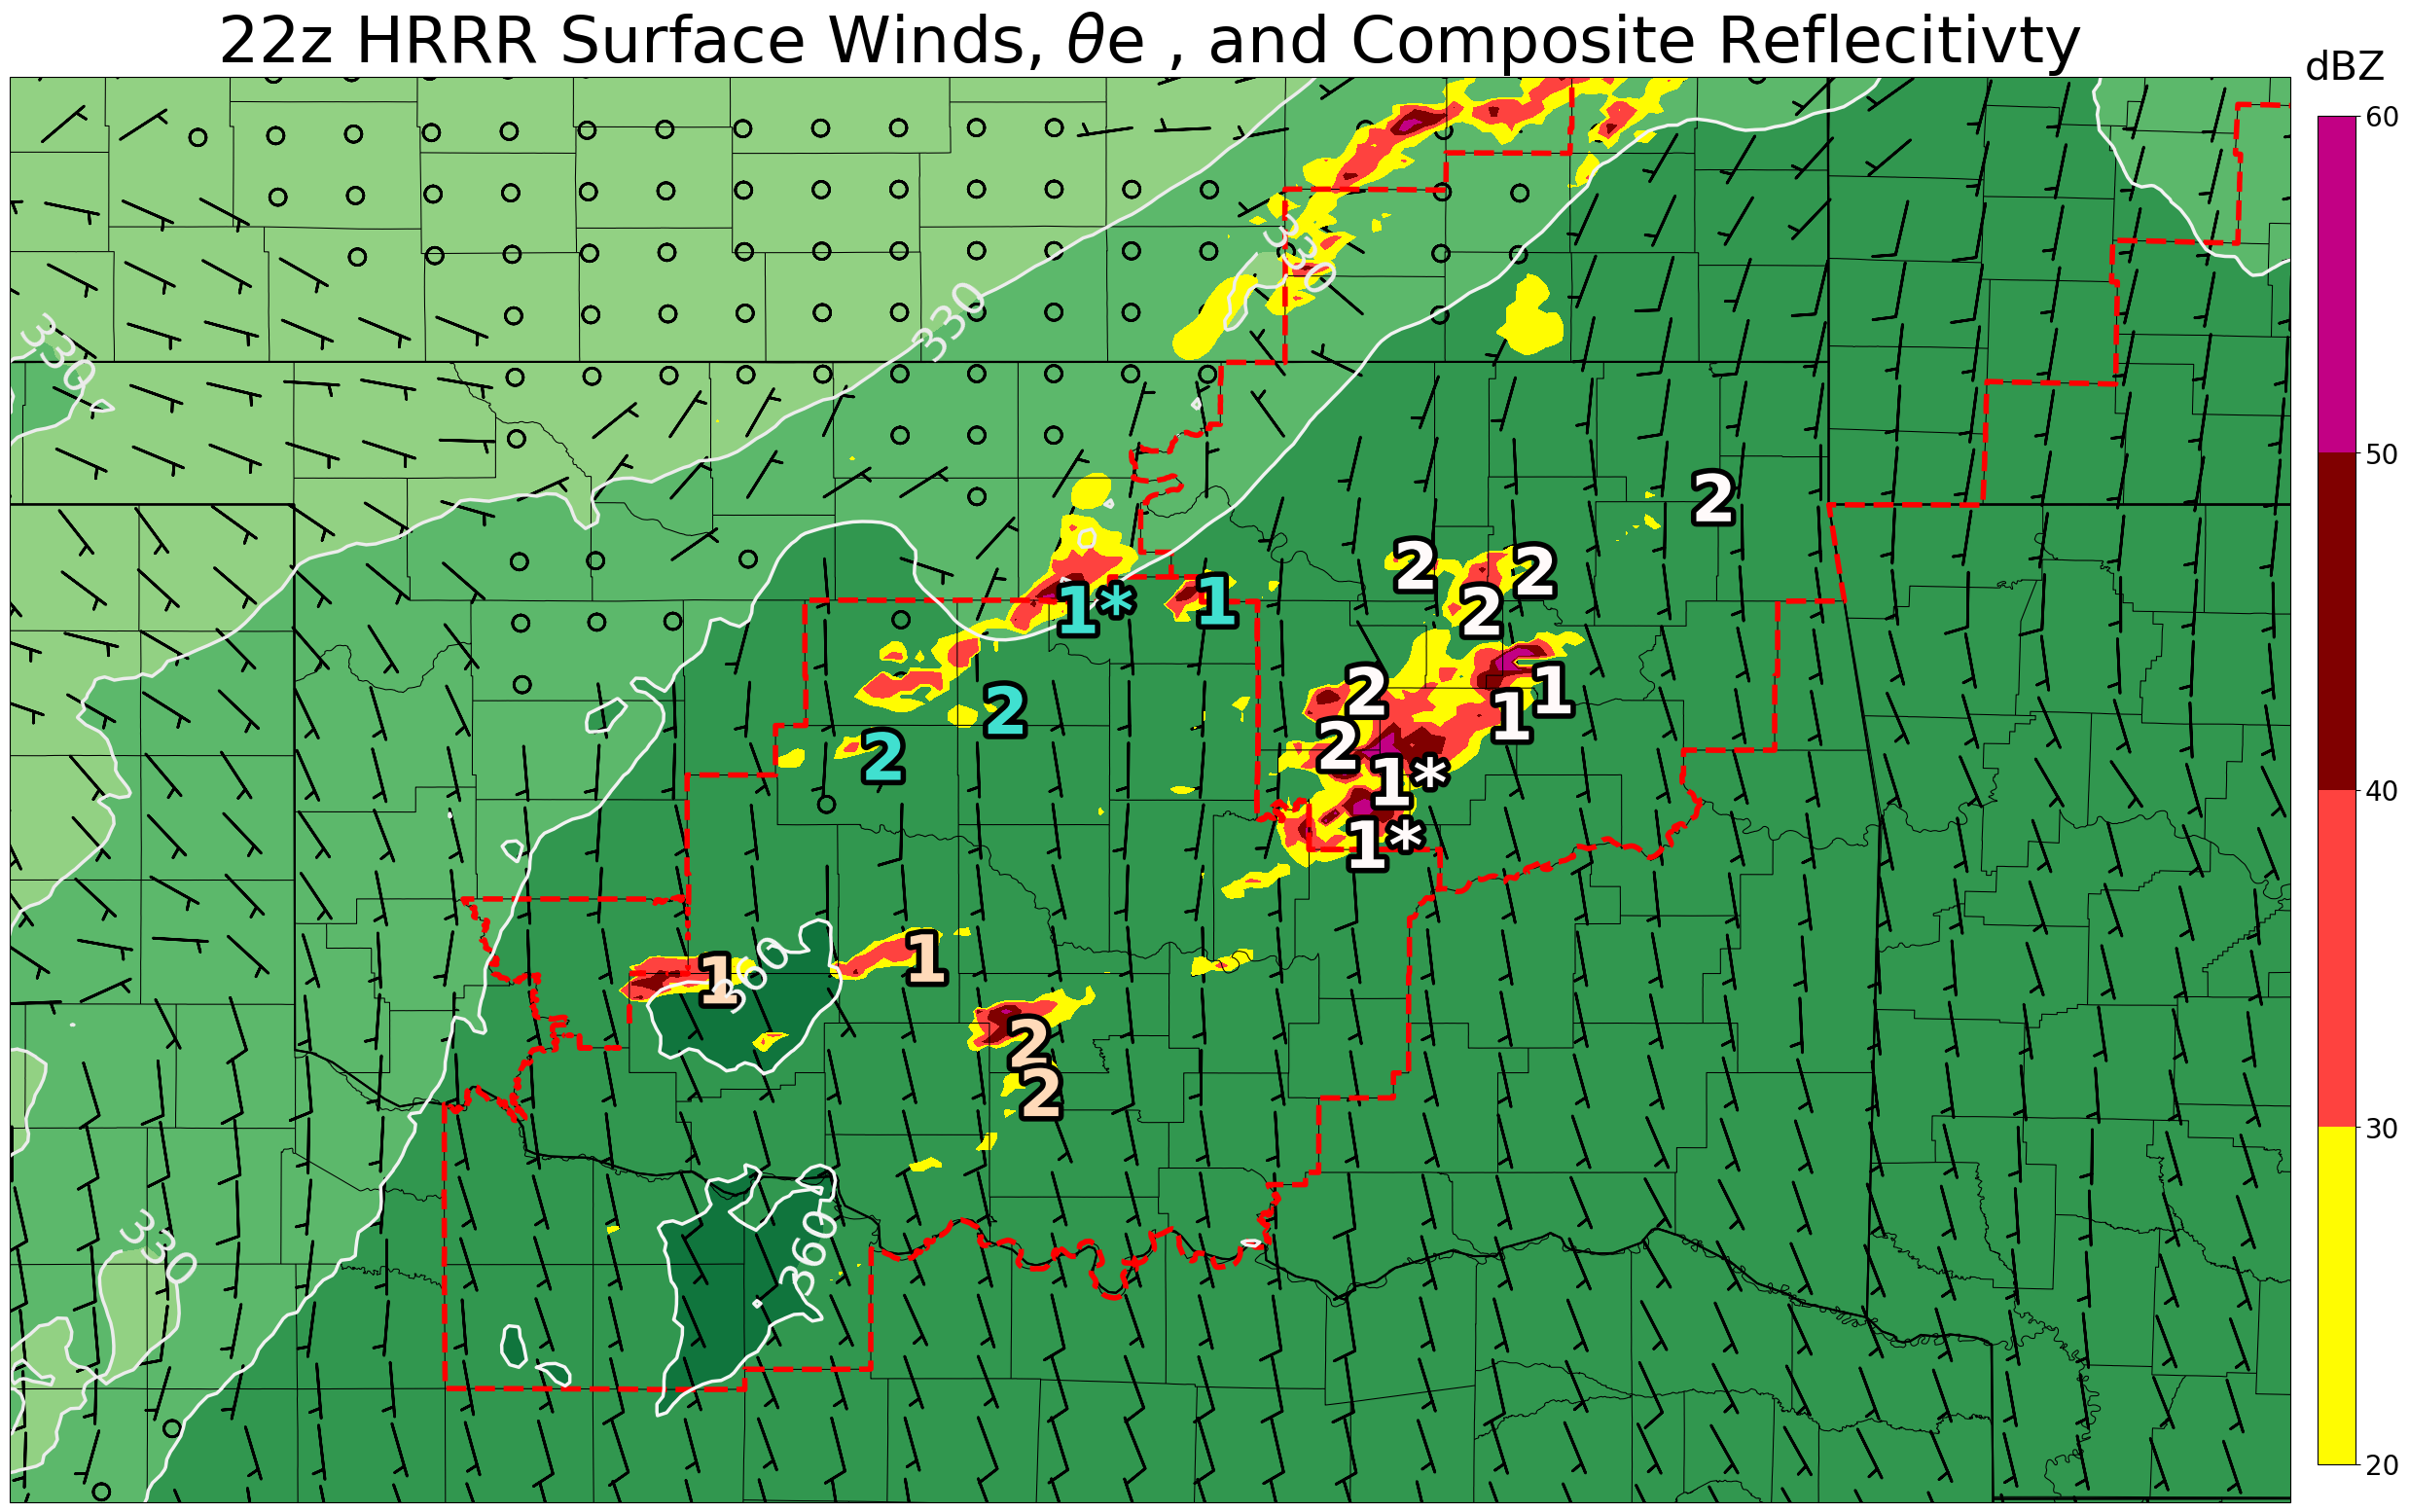

In [15]:
import matplotlib.patheffects as pe

year=2019
month=5
day = 22
hour =22
##############################
run_hour=datetime.datetime(year, month, day, hour)
zarr_ids = [ZarrId(
                run_hour=datetime.datetime(year, month, day, hour) + datetime.timedelta(hours=time_delta),
                level_type="sfc",
                var_level="entire_atmosphere",
                var_name="REFC",
                model_type="anl"
                )
            for time_delta in range(3)] # get 3 hours starting at the given time

dat = load_combined_dataset(zarr_ids)

Hour = hour

time_start = datetime.datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
else:
    hour=str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
else:
    day=str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)
else:
    month=str(month)
year=str(year)

timeIN=str(year+month+day)

fs = s3fs.S3FileSystem(anon=True)
#fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.20190522/conus/')
files = np.array(fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/'))
fileN = np.where(files=='noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/hrrr.t'+hour+'z.wrfnatf00.grib2')
fs.get(files[fileN[0][0]], files[fileN[0][0]].split('/')[-1])
fname=files[fileN[0][0]].split('/')[-1]
c=xr.open_dataset(fname, filter_by_keys={'typeOfLevel': 'hybrid'})
print(fname, "\n")

lev=np.asarray(c.variables['hybrid'][:]) # 0 = lowest level, 49 = highest level
lat=np.asarray(c.variables['latitude'])
lon=((np.asarray(c.variables['longitude'])*-1)+360)*-1

T=np.asarray(c.variables['t'][:]) #K #temperature
q=np.asarray(c.variables['q'][:]) # kg kg**-1 #specific humidity
uwnd=np.asarray(c.variables['u'][:]) #m/s #u wind
vwnd=np.asarray(c.variables['v'][:]) #m/s #v wind
hgt=np.asarray(c.variables['gh'][:]) #geopotential meters #geopotential height
sfc_hgt=np.asarray(c.variables['gh'][0])
VVEL_up=(np.asarray(c.variables['w'][:])) #Pa s**-1 #vertical velocity  
lev=(np.asarray(c.variables['pres'][:])/100.) #hPa #pressure
Td=dewpoint_from_specific_humidity(lev* units('hPa'),T* units('kelvin'),q)
TE = equivalent_potential_temperature(lev* units('hPa'), T* units('kelvin'), Td)

reader = shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader_w= shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e= shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = list(reader_w.geometries())
watch_E = list(reader_e.geometries())
watch_W = cfeature.ShapelyFeature(watch_W, ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(watch_E, ccrs.PlateCarree())

fig=plt.figure(figsize = (36,36))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=4.0, ls='--')
#ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=4.0, ls='--')
ax.set_extent([-101.0, -93.0, 33.0, 38.0])

cmap=plt.get_cmap('YlGn')
cmap=truncate_colormap(cmap,0.0,1.0)
cmap2=plt.get_cmap('Greys_r')
cmap2 = truncate_colormap(cmap2, 0.7, 1.0)
cf1 = ax.contourf(lon, lat, TE[0,:,:], cmap=cmap) # Make a filled contour plot
cf1 = ax.contour(lon, lat, TE[0,:,:], cmap=cmap2, linewidths = 2.5)

#pres = ax.contour(lon,lat,lev[0,:,:],range(890,1010,20),cmap='gray',linewidth=10.0)
ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=9,linewidth=2.0, color='black')



ax.clabel(cf1, inline=1, fontsize=35)


#cbar = plt.colorbar(cf1 , aspect=35, shrink=0.5, pad=0.01)
#cbar = plt.colorbar(cf1, shrink=0.55, pad=0.01)
#cbar.ax.tick_params(labelsize=20)

cmap1 = plt.get_cmap(ctables.REF_pmarsh)
ref_table = truncate_colormap(cmap1, 0.35, 0.75)

#if using model type anl:
cf2 = ax.contourf(dat.REFC[0].longitude, dat.REFC[0].latitude, dat.REFC[0], range(20,70, 10), cmap=ref_table, linewidths=2.5,alpha=1.0) # Make a filled contour plot

#if using model type fcst: 
#cf2 = ax.contour(dat.REFC[0][0].longitude, dat.REFC[0][0].latitude, dat.REFC[0][0], range(20,70, 10), cmap=cmap2, linewidths=3,alpha=1.0) # Make a filled contour plot

cbar2 = plt.colorbar(cf2 , aspect=35, shrink=0.5, pad=0.01)
#cbar = plt.colorbar(cf1, shrink=0.55, pad=0.01)
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label('dBZ', labelpad=-40, y=1.05, rotation=0, fontsize=30)

soundings = pd.read_csv('C:/Users/kyled/Desktop/UNL MS Thesis/2 - QC Near-Inflow Points/Maps/5_22_VerticalProfs_QC_Grouped.csv', usecols=['Time','Grouping', 'Lat', 'Lon','Supercell'])
xGRP1non = soundings[soundings.Time==Hour][soundings.Grouping=="OPW1"][soundings.Supercell=='N']
if len(xGRP1non) != 0:
    for i in range(0,len(xGRP1non)):
        plt.text(xGRP1non['Lon'].iloc[i],xGRP1non['Lat'].iloc[i],"1",fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP1sup = soundings[soundings.Time==Hour][soundings.Grouping==1][soundings.Supercell=='Y']
if len(xGRP1sup) != 0:
    for i in range(0,len(xGRP1sup)):
        plt.text(xGRP1sup['Lon'].iloc[i],xGRP1sup['Lat'].iloc[i],"1*",fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])      
        
xGRP2non = soundings[soundings.Time==Hour][soundings.Grouping=="OPW2"][soundings.Supercell=='N']
if len(xGRP2non) != 0:
    for i in range(0,len(xGRP2non)):
        plt.text(xGRP2non['Lon'].iloc[i],xGRP2non['Lat'].iloc[i],'2',fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP2sup = soundings[soundings.Time==Hour][soundings.Grouping=="OPW2"][soundings.Supercell=='Y']
if len(xGRP2sup) != 0:
    for i in range(0,len(xGRP2sup)):
        plt.text(xGRP2sup['Lon'].iloc[i],xGRP2sup['Lat'].iloc[i],'2*',fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])

xGRP4non = soundings[soundings.Time==Hour][soundings.Grouping=="OPW3"][soundings.Supercell=='N']
if len(xGRP4non) != 0:
    for i in range(0,len(xGRP4non)):
        if xGRP4non['Lat'].iloc[i] >33.00:
            plt.text(xGRP4non['Lon'].iloc[i],xGRP4non['Lat'].iloc[i],"3",fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP4sup = soundings[soundings.Time==Hour][soundings.Grouping=="OPW3"][soundings.Supercell=='Y']
if len(xGRP4sup) != 0:
    for i in range(0,len(xGRP4sup)):
        plt.text(xGRP4sup['Lon'].iloc[i],xGRP4sup['Lat'].iloc[i],"3*",fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])
        
xGRP5non = soundings[soundings.Time==Hour][soundings.Grouping=="OPW4"][soundings.Supercell=='N']
if len(xGRP5non) != 0:
    for i in range(0,len(xGRP5non)):
        plt.text(xGRP5non['Lon'].iloc[i],xGRP5non['Lat'].iloc[i],"4",fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP5sup = soundings[soundings.Time==Hour][soundings.Grouping=="OPW4"][soundings.Supercell=='Y']
if len(xGRP5sup) != 0:
    for i in range(0,len(xGRP5sup)):
        plt.text(xGRP5sup['Lon'].iloc[i],xGRP5sup['Lat'].iloc[i],"4*",fontsize=48,fontweight='bold', color='peachpuff',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
        
xGRP7non = soundings[soundings.Time==Hour][soundings.Grouping=="OPE1"][soundings.Supercell=='N']
if len(xGRP7non) != 0:
    for i in range(0,len(xGRP7non)):
        plt.text(xGRP7non['Lon'].iloc[i],xGRP7non['Lat'].iloc[i],"1",fontsize=48,fontweight='bold', color='snow',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP7sup = soundings[soundings.Time==Hour][soundings.Grouping=="OPE1"][soundings.Supercell=='Y']
if len(xGRP7sup) != 0:
    for i in range(0,len(xGRP7sup)):
        plt.text(xGRP7sup['Lon'].iloc[i],xGRP7sup['Lat'].iloc[i],"1*",fontsize=48,fontweight='bold', color='snow',path_effects=[pe.withStroke(linewidth=8, foreground="black")])

xGRP8non = soundings[soundings.Time==Hour][soundings.Grouping=="OPE2"][soundings.Supercell=='N']
if len(xGRP8non) != 0:
    for i in range(0,len(xGRP8non)):
        plt.text(xGRP8non['Lon'].iloc[i],xGRP8non['Lat'].iloc[i],"2",fontsize=48,fontweight='bold', color='snow',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP8sup = soundings[soundings.Time==Hour][soundings.Grouping=="OPE2"][soundings.Supercell=='Y']
if len(xGRP8sup) != 0:
    for i in range(0,len(xGRP8sup)):
        plt.text(xGRP8sup['Lon'].iloc[i],xGRP8sup['Lat'].iloc[i],"2*",fontsize=48,fontweight='bold', color='snow',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
        
xGRP9non = soundings[soundings.Time==Hour][soundings.Grouping=="OPE3"][soundings.Supercell=='N']
if len(xGRP9non) != 0:
    for i in range(0,len(xGRP9non)):
        plt.text(xGRP9non['Lon'].iloc[i],xGRP9non['Lat'].iloc[i],"3",fontsize=48,fontweight='bold', color='snow',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP9sup = soundings[soundings.Time==Hour][soundings.Grouping=="OPE3"][soundings.Supercell=='Y']
if len(xGRP9sup) != 0:
    for i in range(0,len(xGRP9sup)):
        plt.text(xGRP9sup['Lon'].iloc[i],xGRP9sup['Lat'].iloc[i],"3*",fontsize=48,fontweight='bold', color='snow',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
        
xGRP11non = soundings[soundings.Time==Hour][soundings.Grouping=="BDW1"][soundings.Supercell=='N']
if len(xGRP11non) != 0:
    for i in range(0,len(xGRP11non)):
        plt.text(xGRP11non['Lon'].iloc[i],xGRP11non['Lat'].iloc[i],"1",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP11sup = soundings[soundings.Time==Hour][soundings.Grouping=="BDW1"][soundings.Supercell=='Y']
if len(xGRP11sup) != 0:
    for i in range(0,len(xGRP11sup)):
        plt.text(xGRP11sup['Lon'].iloc[i],xGRP11sup['Lat'].iloc[i],"1*",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])

xGRP12non = soundings[soundings.Time==Hour][soundings.Grouping=="BDW2"][soundings.Supercell=='N']
if len(xGRP12non) != 0:
    for i in range(0,len(xGRP12non)):
        plt.text(xGRP12non['Lon'].iloc[i],xGRP12non['Lat'].iloc[i],"2",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP12sup = soundings[soundings.Time==Hour][soundings.Grouping=="BDW2"][soundings.Supercell=='Y']
if len(xGRP12sup) != 0:
    for i in range(0,len(xGRP12sup)):
        plt.text(xGRP12sup['Lon'].iloc[i],xGRP12sup['Lat'].iloc[i],"2*",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
        
xGRP13non = soundings[soundings.Time==Hour][soundings.Grouping=="BDW3"][soundings.Supercell=='N']
if len(xGRP13non) != 0:
    for i in range(0,len(xGRP13non)):
        plt.text(xGRP13non['Lon'].iloc[i],xGRP13non['Lat'].iloc[i],"5",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP13sup = soundings[soundings.Time==Hour][soundings.Grouping=="BDW3"][soundings.Supercell=='Y']
if len(xGRP13sup) != 0:
    for i in range(0,len(xGRP13sup)):
        plt.text(xGRP13sup['Lon'].iloc[i],xGRP13sup['Lat'].iloc[i],"5*",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])

xGRP14non = soundings[soundings.Time==Hour][soundings.Grouping=="BDW4"][soundings.Supercell=='N']
if len(xGRP14non) != 0:
    for i in range(0,len(xGRP14non)):
        plt.text(xGRP14non['Lon'].iloc[i],xGRP14non['Lat'].iloc[i],"7",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP14sup = soundings[soundings.Time==Hour][soundings.Grouping=="BDW4"][soundings.Supercell=='Y']
if len(xGRP14sup) != 0:
    for i in range(0,len(xGRP14sup)):
        plt.text(xGRP14sup['Lon'].iloc[i],xGRP14sup['Lat'].iloc[i],"7*",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
        
xGRP15non = soundings[soundings.Time==Hour][soundings.Grouping=="BDE1"][soundings.Supercell=='N']
if len(xGRP15non) != 0:
    for i in range(0,len(xGRP15non)):
        plt.text(xGRP15non['Lon'].iloc[i],xGRP15non['Lat'].iloc[i],"3",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP15sup = soundings[soundings.Time==Hour][soundings.Grouping=="BDE1"][soundings.Supercell=='Y']
if len(xGRP15sup) != 0:
    for i in range(0,len(xGRP15sup)):
        plt.text(xGRP15sup['Lon'].iloc[i],xGRP15sup['Lat'].iloc[i],"3*",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
        
xGRP16non = soundings[soundings.Time==Hour][soundings.Grouping=="BDE2"][soundings.Supercell=='N']
if len(xGRP16non) != 0:
    for i in range(0,len(xGRP16non)):
        if xGRP16non['Lat'].iloc[i] <37.75:
            plt.text(xGRP16non['Lon'].iloc[i],xGRP16non['Lat'].iloc[i],"4",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP16sup = soundings[soundings.Time==Hour][soundings.Grouping=="BDE2"][soundings.Supercell=='Y']
if len(xGRP16sup) != 0:
    for i in range(0,len(xGRP16sup)):
        plt.text(xGRP16sup['Lon'].iloc[i],xGRP16sup['Lat'].iloc[i],"4*",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])      
        
xGRP17non = soundings[soundings.Time==Hour][soundings.Grouping=="BDE3"][soundings.Supercell=='N']
if len(xGRP17non) != 0:
    for i in range(0,len(xGRP17non)):
        plt.text(xGRP17non['Lon'].iloc[i],xGRP17non['Lat'].iloc[i],"6",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])
xGRP17sup = soundings[soundings.Time==Hour][soundings.Grouping=="BDE3"][soundings.Supercell=='Y']
if len(xGRP17sup) != 0:
    for i in range(0,len(xGRP17sup)):
        plt.text(xGRP17sup['Lon'].iloc[i],xGRP17sup['Lat'].iloc[i],"6*",fontsize=48,fontweight='bold', color='turquoise',path_effects=[pe.withStroke(linewidth=8, foreground="black")])      
        
plt.title(str(hour)+'z HRRR Surface Winds, 'r'$\theta$e , and Composite Reflecitivty', fontsize=48)
plt.savefig(r"C:\Users\kyled\Desktop\UNL MS Thesis\2 - QC Near-Inflow Points\Maps\BDY_HRRR2_"+str(hour)+"z.png", bbox_inches='tight')

In [4]:
#lev[0,:,:]
np.amax(lev[0,327:513,790:1040])

NameError: name 'lev' is not defined

# HRRR Radar Plotting

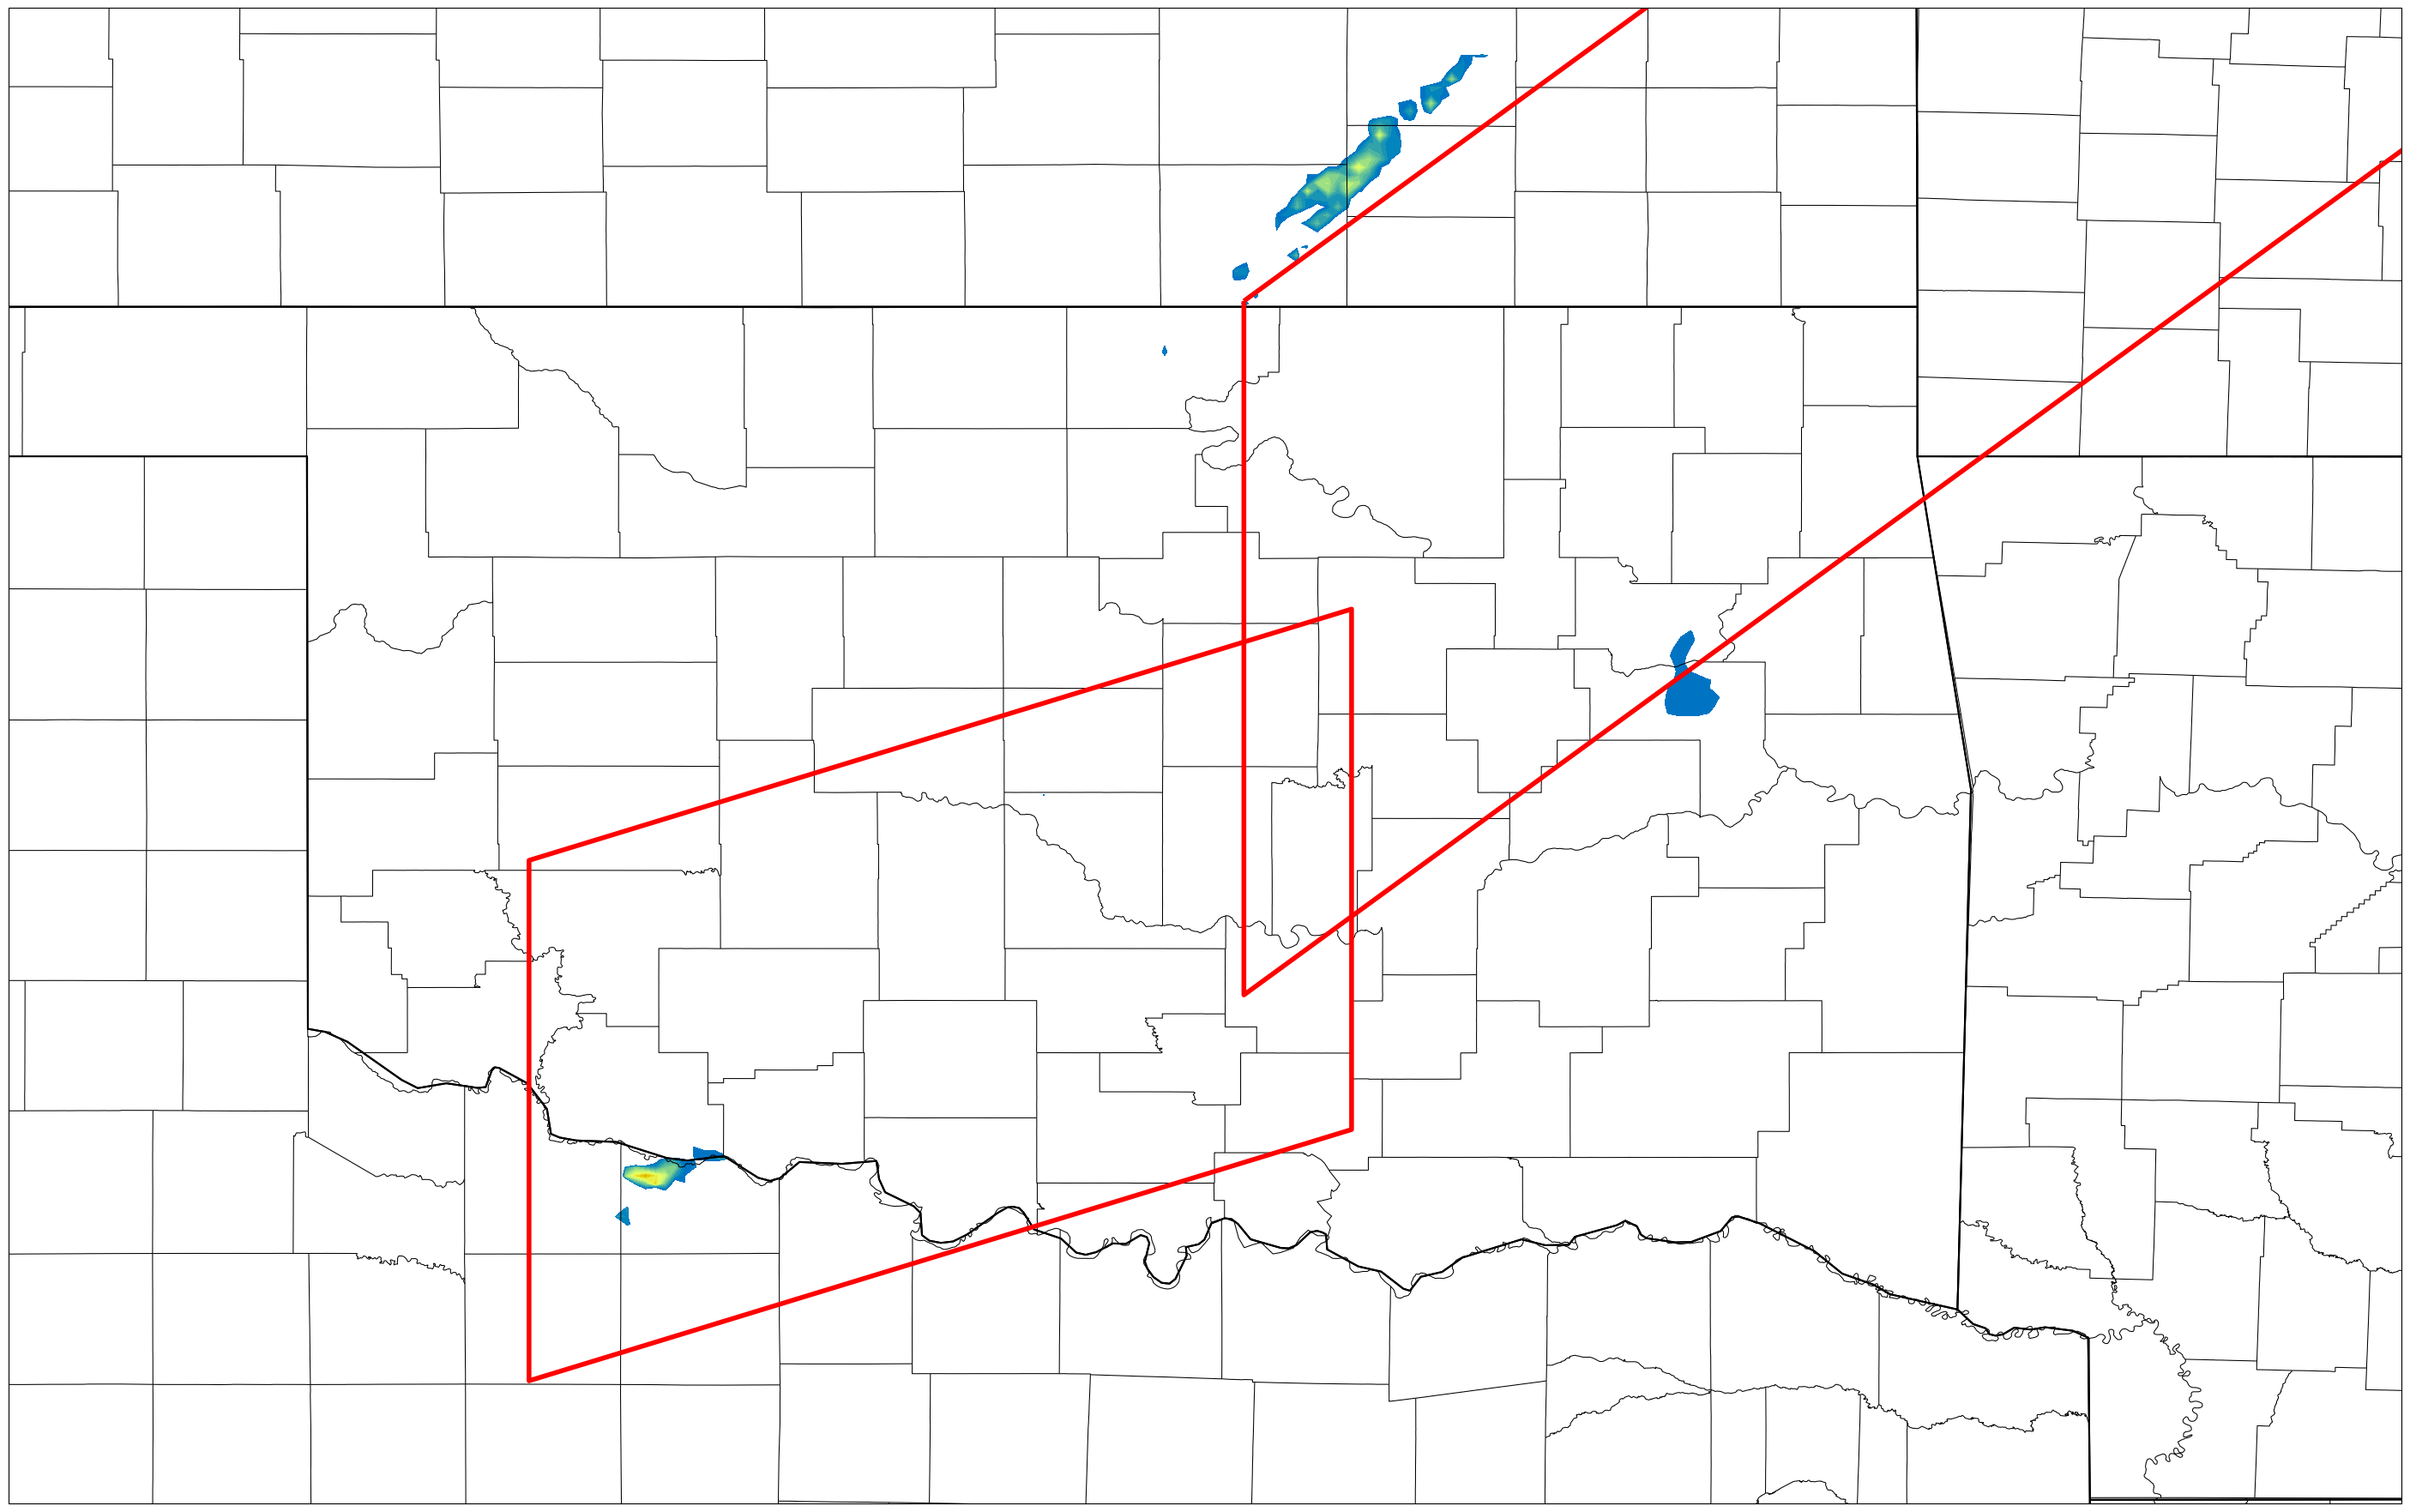

In [23]:
year=2019
month=5
day = 22
hour = 19
##############################
run_hour=datetime.datetime(year, month, day, hour)
zarr_ids = [ZarrId(
                run_hour=datetime.datetime(year, month, day, hour) + datetime.timedelta(hours=time_delta),
                level_type="sfc",
                var_level="entire_atmosphere",
                var_name="REFC",
                model_type="anl"
                )
            for time_delta in range(3)] # get 3 hours starting at the given time

dat = load_combined_dataset(zarr_ids)

reader = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader1 = shpreader.Reader(r"D:\THESIS\Thesis GIS Data\watches_201905221800_201905222232\watches_201905221800_201905222232.shp")
watchboxes = list(reader1.geometries())
WATCHES = cfeature.ShapelyFeature(watchboxes, ccrs.PlateCarree())

proj = ccrs.PlateCarree()

fig=plt.figure(figsize = (36,36))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
ax.add_feature(WATCHES, facecolor='none', edgecolor='red', linewidth=4.0)
ax.set_extent([-101.0, -93.0, 33.0, 38.0])

cmap1 = plt.get_cmap(ctables.REF_pmarsh)
ref_table = truncate_colormap(cmap1, 0, 1)

#if using model type anl:
cf1 = ax.contourf(dat.REFC[0].longitude, dat.REFC[0].latitude, dat.REFC[0], range(20,72, 2), cmap='HomeyerRainbow') # Make a filled contour plot
#if using model type fcst:
#cf1 = ax.contourf(dat.REFC[0][0].longitude, dat.REFC[0][0].latitude, dat.REFC[0][0], range(20,70, 2), cmap=ref_table) # Make a filled contour plot

#cbar = plt.colorbar(cf1 , aspect=35, shrink=0.5, pad=0.01)
#cbar = plt.colorbar(cf1, shrink=0.55, pad=0.01)
#cbar.ax.tick_params(labelsize=20)

#plt.title(str(hour)+'z HRRR Composite Reflecitivty', fontsize=36)

# Pull HRRR Vertical Profiles at given time/location

# Create Comparison Soundings w/ Observed Data

# Create Composite Soundings within Clusters

C:\Users\kyled\AppData\Local\Temp\ipykernel_25012\4003548890.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EW=='W'][df.Time==time]['Profile_Number']:
C:\Users\kyled\AppData\Local\Temp\ipykernel_25012\4003548890.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EW=='E'][df.Time==time]['Profile_Number']:


In [321]:
profW = profile.create_profile(profile='default', pres=combinedP_1['meanP'], hght=combinedH_1['meanH'], tmpc=combinedT_1['meanT'], dwpc=combinedTd_1['meanTd'], u=combinedU_1['meanU'], v=combinedV_1['meanV'], missing=-9999)
profE = profile.create_profile(profile='default', pres=combinedP_2['meanP'], hght=combinedH_2['meanH'], tmpc=combinedT_2['meanT'], dwpc=combinedTd_2['meanTd'], u=combinedU_2['meanU'], v=combinedV_2['meanV'], missing=-9999)
#combinedP_1['meanP']

interpP_W = []
interpT_W = []
interpTd_W = []
interpH_W = []
interpU_W = []
interpV_W = []

interpP_E = []
interpT_E = []
interpTd_E = []
interpH_E = []
interpU_E = []
interpV_E = []

sfcP_W = sharppy.sharptab.interp.pres(profW, 0)
sfcP_E = sharppy.sharptab.interp.pres(profE, 0)
sfcT_W = sharppy.sharptab.interp.temp(profW, sfcP_W)
sfcT_E = sharppy.sharptab.interp.temp(profE, sfcP_E)
sfcTd_W = sharppy.sharptab.interp.dwpt(profW, sfcP_W)
sfcTd_E = sharppy.sharptab.interp.dwpt(profE, sfcP_E)
sfcWind_W = sharppy.sharptab.interp.components(profW, sfcP_W)
sfcWind_E = sharppy.sharptab.interp.components(profE, sfcP_E)
sfcU_W = sfcWind_W[0]
sfcU_E = sfcWind_E[0]
sfcV_W = sfcWind_W[1]
sfcV_E = sfcWind_E[1]

interpT_W.append(sfcT_W)
interpTd_W.append(sfcTd_W)
interpH_W.append(0)
interpU_W.append(sfcU_W)
interpV_W.append(sfcV_W)

interpT_E.append(sfcT_E)
interpTd_E.append(sfcTd_E)
interpH_E.append(0)
interpU_E.append(sfcU_E)
interpV_E.append(sfcV_E)

interpP = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

interpP_W = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_E = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_W.insert(0, sfcP_W)
interpP_E.insert(0, sfcP_E)

for i in interpP:
    H_west = sharppy.sharptab.interp.hght(profW, i)
    H_east = sharppy.sharptab.interp.hght(profE, i)
    T_west = sharppy.sharptab.interp.temp(profW, i)
    T_east = sharppy.sharptab.interp.temp(profE, i)
    Td_west = sharppy.sharptab.interp.dwpt(profW, i)
    Td_east = sharppy.sharptab.interp.dwpt(profE, i)
    Wind_west = sharppy.sharptab.interp.components(profW, i)
    Wind_east = sharppy.sharptab.interp.components(profE, i)
    U_west = Wind_west[0]
    U_east = Wind_east[0]
    V_west = Wind_west[1]
    V_east = Wind_east[1]
    
    interpT_W.append(T_west)
    interpTd_W.append(Td_west)
    interpH_W.append(H_west)
    interpU_W.append(U_west)
    interpV_W.append(V_west)

    interpT_E.append(T_east)
    interpTd_E.append(Td_east)
    interpH_E.append(H_east)
    interpU_E.append(U_east)
    interpV_E.append(V_east)
    
combinedP_W=np.asarray(interpP_W)
combinedT_W=np.asarray(interpT_W)
combinedTd_W=np.asarray(interpTd_W)
combinedH_W=np.asarray(interpH_W)
combinedU_W=np.asarray(interpU_W)
combinedV_W=np.asarray(interpV_W)

combinedP_E=np.asarray(interpP_E)
combinedT_E=np.asarray(interpT_E)
combinedTd_E=np.asarray(interpTd_E)
combinedH_E=np.asarray(interpH_E)
combinedU_E=np.asarray(interpU_E)
combinedV_E=np.asarray(interpV_E)

D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


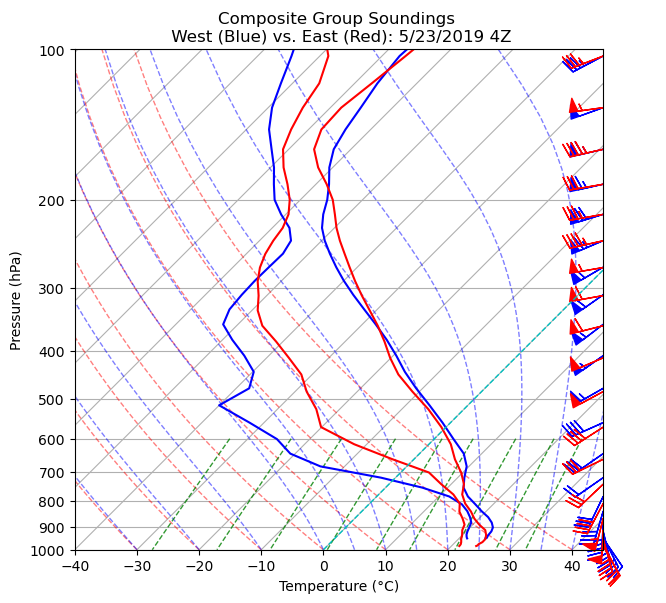

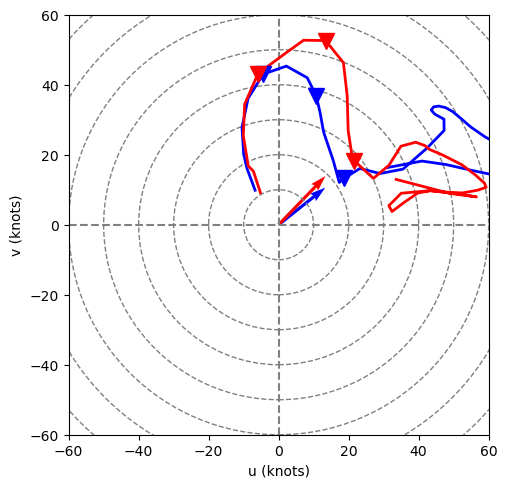

In [322]:
fig = plt.figure(figsize=(15, 12))
gs=gridspec.GridSpec(nrows=4, ncols=6)
gs=gridspec.GridSpec(nrows=1, ncols=2)

skew = SkewT(fig, rotation=45, subplot=gs[0,0])
#skew = SkewT(fig, rotation=45, subplot=gs[0:3, 0:3])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

hpa100 = np.where(combinedP_1['meanP'] >=100)

skew.plot(combinedP_1['meanP'], combinedT_1['meanT'], 'b')
skew.plot(combinedP_1['meanP'], combinedTd_1['meanTd'], 'b')
skew.plot_barbs(combinedP_1['meanP'][hpa100[0]][::2], combinedU_1['meanU'][hpa100[0]][::2], combinedV_1['meanV'][hpa100[0]][::2], color='blue')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

skew.plot(combinedP_2['meanP'], combinedT_2['meanT'], 'r')
skew.plot(combinedP_2['meanP'], combinedTd_2['meanTd'], 'r')
skew.plot_barbs(combinedP_2['meanP'][hpa100[0]][::2], combinedU_2['meanU'][hpa100[0]][::2], combinedV_2['meanV'][hpa100[0]][::2], color='red')

#skew.plot(p2, T2, 'b')
#skew.plot(p2, Td2, 'b')
#skew.plot_barbs(p2[::150], u2[::150], v2[::150], color='blue')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.

#lcl_pressure, lcl_temperature = lcl(p[0], T[0], Td[0])
#skew.plot(lcl_pressure, lcl_temperature, marker=11, markerfacecolor='black', markers)

# Calculate full parcel profile and add to plot as black line
#prof = parcel_profile(p, T[0], Td[0]).to('degC')

#prof1 = mixed_parcel(p, T, Td)
#prof = parcel_profile(p, prof1[1], prof1[2]).to('degC')
#prof = parcel_profile(p, mlpcl.tmpc*units.degree_Celsius, mlpcl.dwpc*units.degree_Celsius).to('degC')


#mlpcl.tmpc*units.degree_Celsius
#skew.plot(p, prof, 'k', linewidth=1.5, linestyle='--')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td)
#skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-20, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-30, color='c', linestyle='--', linewidth=1)

#hgt0c = (mupcl.hght0c*units.meter).to(units.feet)
#hgtm20c = (mupcl.hghtm20c*units.meter).to(units.feet)
#hgtm30c = (mupcl.hghtm30c*units.meter).to(units.feet)

# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=1)
skew.plot_moist_adiabats(linewidth=1)
skew.plot_mixing_lines(linewidth=1)

plt.title("Composite Group Soundings \n West (Blue) vs. East (Red): 5/23/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/23/2019 "+str(time)+"Z")

# Add a secondary axis that automatically converts between pressure and height
# assuming a standard atmosphere. The value of -0.12 puts the secondary axis
# 0.12 normalized (0 to 1) coordinates left of the original axis.
#secax = skew.ax.secondary_yaxis(-0.14,
#    functions=(lambda p: pressure_to_height_std(units.Quantity(p, 'mbar')).m_as('feet'),
#               lambda h: height_to_pressure_std(units.Quantity(h, 'feet')).m))

fig = plt.figure(figsize=(12, 12))
gs=gridspec.GridSpec(2,2)

ax = fig.add_subplot(gs[1,1])
#ax = fig.add_subplot(gs[1:2,3:])

h = Hodograph(ax, component_range=60.)
h.add_grid(increment=10)
h.ax.set_xlabel('u (knots)')
h.ax.set_ylabel('v (knots)')

height_scale = combinedH_1['meanH'][hpa100[0]].values
height = combinedH_1['meanH'][hpa100[0]].values * units.m

h.plot(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], linewidth=2, color='blue')
h.plot(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], linewidth=2, color='red')
#h.plot_colormapped(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Blues,intervals=[10,15,25], linewidth=2)
#h.plot_colormapped(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Reds,intervals=[10,15,25], linewidth=2)

#h.plot(combinedU_1['meanU'][hpa100[0]][13],combinedV_1['meanV'][hpa100[0]][13], marker="s")
#h.ax.text(combinedU_1['meanU'][hpa100[0]][5],combinedV_1['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')
#h.ax.text(combinedU_2['meanU'][hpa100[0]][5],combinedV_2['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')

val500W = find_nearest(combinedH_1['meanH'][hpa100[0]], 500)
val500posW = np.where(combinedH_1['meanH'][hpa100[0]] == val500W)
v500W = val500posW[0][0]

val1000W = find_nearest(combinedH_1['meanH'][hpa100[0]], 1000)
val1000posW = np.where(combinedH_1['meanH'][hpa100[0]] == val1000W)
v1000W = val1000posW[0][0]

val3000W = find_nearest(combinedH_1['meanH'][hpa100[0]], 3000)
val3000posW = np.where(combinedH_1['meanH'][hpa100[0]] == val3000W)
v3000W = val3000posW[0][0]

val500E = find_nearest(combinedH_1['meanH'][hpa100[0]], 500)
val500posE = np.where(combinedH_1['meanH'][hpa100[0]] == val500E)
v500E = val500posE[0][0]

val1000E = find_nearest(combinedH_1['meanH'][hpa100[0]], 1000)
val1000posE = np.where(combinedH_1['meanH'][hpa100[0]] == val1000E)
v1000E = val1000posE[0][0]

val3000E = find_nearest(combinedH_1['meanH'][hpa100[0]], 3000)
val3000posE = np.where(combinedH_1['meanH'][hpa100[0]] == val3000E)
v3000E = val3000posE[0][0]


h.plot(combinedU_1['meanU'][hpa100[0]][v500W],combinedV_1['meanV'][hpa100[0]][v500W], marker="v", color='blue', markersize=12)
h.plot(combinedU_1['meanU'][hpa100[0]][v1000W],combinedV_1['meanV'][hpa100[0]][v1000W], marker="v", color='blue', markersize=12)
h.plot(combinedU_1['meanU'][hpa100[0]][v3000W],combinedV_1['meanV'][hpa100[0]][v3000W], marker="v", color='blue', markersize=12)

h.plot(combinedU_2['meanU'][hpa100[0]][v500E],combinedV_2['meanV'][hpa100[0]][v500E], marker="v", color='red', markersize=12)
h.plot(combinedU_2['meanU'][hpa100[0]][v1000E],combinedV_2['meanV'][hpa100[0]][v1000E], marker="v", color='red', markersize=12)
h.plot(combinedU_2['meanU'][hpa100[0]][v3000E],combinedV_2['meanV'][hpa100[0]][v3000E], marker="v", color='red', markersize=12)


right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_1['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_1['meanH'][hpa100[0]])* units.meter)
h.wind_vectors(right1[0], right1[1], color='blue')
#h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')


right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_2['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_2['meanH'][hpa100[0]])* units.meter)
h.wind_vectors(right2[0], right2[1], color='red')

#right_mover_direction = wind_direction(right1[0],right1[1])
#right_mover_speed = wind_speed(right1[0],right1[1])
#print(right_mover_speed, right_mover_direction)

#right_mover_direction = wind_direction(right2[0],right2[1])
#right_mover_speed = wind_speed(right2[0],right2[1])
#print(right_mover_speed, right_mover_direction)

#left_mover_direction = get_wind_dir(left[0],left[1])
#left_mover_speed = get_wind_speed(left[0],left[1])
#print(left_mover_speed, left_mover_direction)

#mean_direction = get_wind_dir(mean[0],mean[1])
#mean_speed = get_wind_speed(mean[0],mean[1])
#print(mean_speed, mean_direction)
#plt.figtext(0.15, 0.38, '0°C Height: '+str(int(hgt0c.magnitude))+' ft', fontsize = 12)

# Show the plot
plt.show()

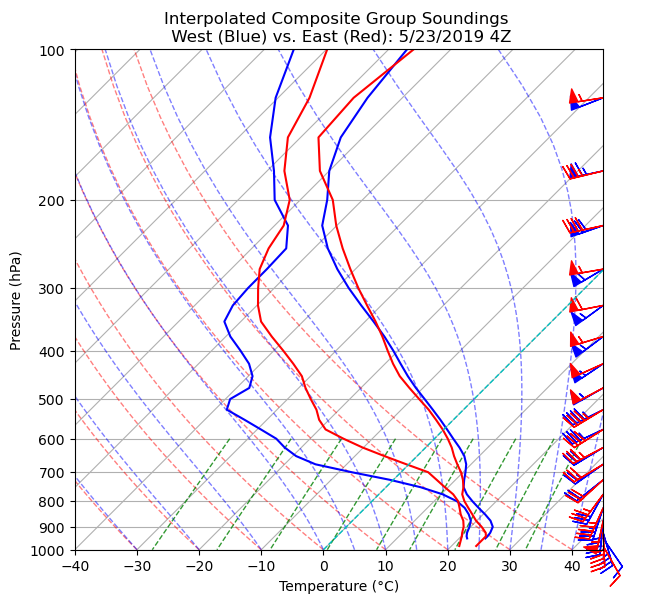

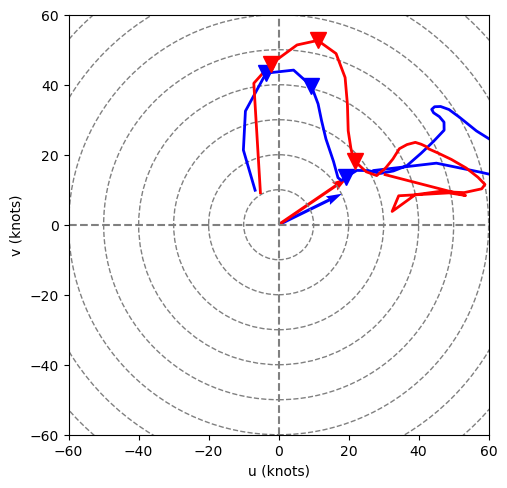

In [323]:
fig = plt.figure(figsize=(15, 12))
gs=gridspec.GridSpec(nrows=4, ncols=6)
gs=gridspec.GridSpec(nrows=1, ncols=2)

skew = SkewT(fig, rotation=45, subplot=gs[0,0])
#skew = SkewT(fig, rotation=45, subplot=gs[0:3, 0:3])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

hpa100 = np.where(combinedP_W >=100)

skew.plot(combinedP_W, combinedT_W, 'b')
skew.plot(combinedP_W, combinedTd_W, 'b')
skew.plot_barbs(combinedP_W[hpa100[0]][::2], combinedU_W[hpa100[0]][::2], combinedV_W[hpa100[0]][::2], color='blue')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

skew.plot(combinedP_E, combinedT_E, 'r')
skew.plot(combinedP_E, combinedTd_E, 'r')
skew.plot_barbs(combinedP_E[hpa100[0]][::2], combinedU_E[hpa100[0]][::2], combinedV_E[hpa100[0]][::2], color='red')

#skew.plot(p2, T2, 'b')
#skew.plot(p2, Td2, 'b')
#skew.plot_barbs(p2[::150], u2[::150], v2[::150], color='blue')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.

#lcl_pressure, lcl_temperature = lcl(p[0], T[0], Td[0])
#skew.plot(lcl_pressure, lcl_temperature, marker=11, markerfacecolor='black', markers)

# Calculate full parcel profile and add to plot as black line
#prof = parcel_profile(p, T[0], Td[0]).to('degC')

#prof1 = mixed_parcel(p, T, Td)
#prof = parcel_profile(p, prof1[1], prof1[2]).to('degC')
#prof = parcel_profile(p, mlpcl.tmpc*units.degree_Celsius, mlpcl.dwpc*units.degree_Celsius).to('degC')


#mlpcl.tmpc*units.degree_Celsius
#skew.plot(p, prof, 'k', linewidth=1.5, linestyle='--')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td)
#skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-20, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-30, color='c', linestyle='--', linewidth=1)

#hgt0c = (mupcl.hght0c*units.meter).to(units.feet)
#hgtm20c = (mupcl.hghtm20c*units.meter).to(units.feet)
#hgtm30c = (mupcl.hghtm30c*units.meter).to(units.feet)

# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=1)
skew.plot_moist_adiabats(linewidth=1)
skew.plot_mixing_lines(linewidth=1)

plt.title("Interpolated Composite Group Soundings \n West (Blue) vs. East (Red): 5/23/2019 "+str(time)+"Z")
#plt.title("Interpolated Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/23/2019 "+str(time)+"Z")

# Add a secondary axis that automatically converts between pressure and height
# assuming a standard atmosphere. The value of -0.12 puts the secondary axis
# 0.12 normalized (0 to 1) coordinates left of the original axis.
#secax = skew.ax.secondary_yaxis(-0.14,
#    functions=(lambda p: pressure_to_height_std(units.Quantity(p, 'mbar')).m_as('feet'),
#               lambda h: height_to_pressure_std(units.Quantity(h, 'feet')).m))

fig = plt.figure(figsize=(12, 12))
gs=gridspec.GridSpec(2,2)

ax = fig.add_subplot(gs[1,1])
#ax = fig.add_subplot(gs[1:2,3:])

h = Hodograph(ax, component_range=60.)
h.add_grid(increment=10)
h.ax.set_xlabel('u (knots)')
h.ax.set_ylabel('v (knots)')

height_scale = combinedH_W[hpa100[0]]
height = combinedH_W[hpa100[0]] * units.m

h.plot(combinedU_W[hpa100[0]],combinedV_W[hpa100[0]], linewidth=2, color='blue')
h.plot(combinedU_E[hpa100[0]],combinedV_E[hpa100[0]], linewidth=2, color='red')
#h.plot_colormapped(combinedU_W['meanU'][hpa100[0]],combinedV_W['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Blues,intervals=[10,15,25], linewidth=2)
#h.plot_colormapped(combinedU_E['meanU'][hpa100[0]],combinedV_E['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Reds,intervals=[10,15,25], linewidth=2)

val500W = find_nearest(combinedH_W[hpa100[0]], 500)
val500posW = np.where(combinedH_W[hpa100[0]] == val500W)
v500W = val500posW[0][0]

val1000W = find_nearest(combinedH_W[hpa100[0]], 1000)
val1000posW = np.where(combinedH_W[hpa100[0]] == val1000W)
v1000W = val1000posW[0][0]

val3000W = find_nearest(combinedH_W[hpa100[0]], 3000)
val3000posW = np.where(combinedH_W[hpa100[0]] == val3000W)
v3000W = val3000posW[0][0]

val500E = find_nearest(combinedH_E[hpa100[0]], 500)
val500posE = np.where(combinedH_E[hpa100[0]] == val500E)
v500E = val500posE[0][0]

val1000E = find_nearest(combinedH_E[hpa100[0]], 1000)
val1000posE = np.where(combinedH_E[hpa100[0]] == val1000E)
v1000E = val1000posE[0][0]

val3000E = find_nearest(combinedH_E[hpa100[0]], 3000)
val3000posE = np.where(combinedH_E[hpa100[0]] == val3000E)
v3000E = val3000posE[0][0]


h.plot(combinedU_W[hpa100[0]][v500W],combinedV_W[hpa100[0]][v500W], marker="v", color='blue', markersize=12)
h.plot(combinedU_W[hpa100[0]][v1000W],combinedV_W[hpa100[0]][v1000W], marker="v", color='blue', markersize=12)
h.plot(combinedU_W[hpa100[0]][v3000W],combinedV_W[hpa100[0]][v3000W], marker="v", color='blue', markersize=12)

h.plot(combinedU_E[hpa100[0]][v500E],combinedV_E[hpa100[0]][v500E], marker="v", color='red', markersize=12)
h.plot(combinedU_E[hpa100[0]][v1000E],combinedV_E[hpa100[0]][v1000E], marker="v", color='red', markersize=12)
h.plot(combinedU_E[hpa100[0]][v3000E],combinedV_E[hpa100[0]][v3000E], marker="v", color='red', markersize=12)


#h.ax.text(combinedU_W[hpa100[0]][5],combinedV_W[hpa100[0]][5],'M',fontsize=36,fontweight='bold', color='blue')

right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_W[hpa100[0]])* units.hPa, np.asarray(combinedU_W[hpa100[0]])* units.knot,np.asarray(combinedV_W[hpa100[0]])* units.knot, np.asarray(combinedH_W[hpa100[0]])* units.meter)
h.wind_vectors(right1[0], right1[1], color='blue')
#h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')


right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_E[hpa100[0]])* units.hPa, np.asarray(combinedU_E[hpa100[0]])* units.knot,np.asarray(combinedV_E[hpa100[0]])* units.knot, np.asarray(combinedH_E[hpa100[0]])* units.meter)
h.wind_vectors(right2[0], right2[1], color='red')

#right_mover_direction = wind_direction(right1[0],right1[1])
#right_mover_speed = wind_speed(right1[0],right1[1])
#print(right_mover_speed, right_mover_direction)

#right_mover_direction = wind_direction(right2[0],right2[1])
#right_mover_speed = wind_speed(right2[0],right2[1])
#print(right_mover_speed, right_mover_direction)

#left_mover_direction = get_wind_dir(left[0],left[1])
#left_mover_speed = get_wind_speed(left[0],left[1])
#print(left_mover_speed, left_mover_direction)

#mean_direction = get_wind_dir(mean[0],mean[1])
#mean_speed = get_wind_speed(mean[0],mean[1])
#print(mean_speed, mean_direction)
#plt.figtext(0.15, 0.38, '0°C Height: '+str(int(hgt0c.magnitude))+' ft', fontsize = 12)

# Show the plot
plt.show()

# INTERPOLATE FIRST, THEN AVERAGE

In [327]:
import glob
import os
df = pd.read_excel("C:/Users/kyled/Desktop/HRRRouts/combined_EW.xlsx")
folder = r"C:\Users\kyled\Desktop\HRRROuts\Soundings"
col_names = ['pressure', 'temperature', 'dewpoint', 'height', 'uwnd', 'vwnd']

time = 20

combinedP_1 = []
combinedT_1 = []
combinedTd_1 = []
combinedH_1 = []
combinedU_1 = []
combinedV_1 = []

combinedP_2 = []
combinedT_2 = []
combinedTd_2 = []
combinedH_2 = []
combinedU_2 = []
combinedV_2 = []

interpP_W = []
interpT_W = []
interpTd_W = []
interpH_W = []
interpU_W = []
interpV_W = []

interpP_E = []
interpT_E = []
interpTd_E = []
interpH_E = []
interpU_E = []
interpV_E = []

interpP_W = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_E = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EW=='W'][df.Time==time]['Profile_Number']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if i <10:
        i = '0'+str(i)
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_*.txt')
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profW = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
        
        sfcP_W = sharppy.sharptab.interp.pres(profW, 0)
        sfcT_W = sharppy.sharptab.interp.temp(profW, sfcP_W)
        sfcTd_W = sharppy.sharptab.interp.dwpt(profW, sfcP_W)
        sfcWind_W = sharppy.sharptab.interp.components(profW, sfcP_W)
        sfcU_W = sfcWind_W[0]
        sfcV_W = sfcWind_W[1]
        
        interpT_W.append(sfcT_W)
        interpTd_W.append(sfcTd_W)
        interpH_W.append(0)
        interpU_W.append(sfcU_W)
        interpV_W.append(sfcV_W)
        interpP_W.insert(0, sfcP_W)
        
        for k in interpP_W:
            H_west = sharppy.sharptab.interp.hght(profW, k)
            T_west = sharppy.sharptab.interp.temp(profW, k)
            Td_west = sharppy.sharptab.interp.dwpt(profW, k)
            Wind_west = sharppy.sharptab.interp.components(profW, k)
            U_west = Wind_west[0]
            V_west = Wind_west[1]

            interpT_W.append(T_west)
            interpTd_W.append(Td_west)
            interpH_W.append(H_west)
            interpU_W.append(U_west)
            interpV_W.append(V_west)
            
        combinedP_W=np.asarray(interpP_W)
        combinedT_W=np.asarray(interpT_W)
        combinedTd_W=np.asarray(interpTd_W)
        combinedH_W=np.asarray(interpH_W)
        combinedU_W=np.asarray(interpU_W)
        combinedV_W=np.asarray(interpV_W)      
        
        combinedP_1.append(combinedP_W)
        combinedT_1.append(combinedT_W)
        combinedTd_1.append(combinedTd_W)
        combinedH_1.append(combinedH_W)
        combinedU_1.append(combinedU_W)
        combinedV_1.append(combinedV_W)
        
#for i in df[df.Grouping==2][df.Time==20]['Profile_Number']:
for i in df[df.EW=='E'][df.Time==time]['Profile_Number']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if i <10:
        i = '0'+str(i)
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_*.txt')
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profE = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
        
        sfcP_E = sharppy.sharptab.interp.pres(profE, 0)
        sfcT_E = sharppy.sharptab.interp.temp(profE, sfcP_E)
        sfcTd_E = sharppy.sharptab.interp.dwpt(profE, sfcP_E)
        sfcWind_E = sharppy.sharptab.interp.components(profE, sfcP_E)
        sfcU_E = sfcWind_E[0]
        sfcV_E = sfcWind_E[1]
        
        interpT_E.append(sfcT_E)
        interpTd_E.append(sfcTd_E)
        interpH_E.append(0)
        interpU_E.append(sfcU_E)
        interpV_E.append(sfcV_E)
        interpP_E.insert(0, sfcP_E)
        
        for k in interpP_E:
            H_east = sharppy.sharptab.interp.hght(profE, k)
            T_east = sharppy.sharptab.interp.temp(profE, k)
            Td_east = sharppy.sharptab.interp.dwpt(profE, k)
            Wind_east = sharppy.sharptab.interp.components(profE, k)
            U_east = Wind_east[0]
            V_east = Wind_east[1]

            interpT_E.append(T_east)
            interpTd_E.append(Td_east)
            interpH_E.append(H_east)
            interpU_E.append(U_east)
            interpV_E.append(V_east)
            
        combinedP_E=np.asarray(interpP_E)
        combinedT_E=np.asarray(interpT_E)
        combinedTd_E=np.asarray(interpTd_E)
        combinedH_E=np.asarray(interpH_E)
        combinedU_E=np.asarray(interpU_E)
        combinedV_E=np.asarray(interpV_E)      
        
        combinedP_2.append(combinedP_E)
        combinedT_2.append(combinedT_E)
        combinedTd_2.append(combinedTd_E)
        combinedH_2.append(combinedH_E)
        combinedU_2.append(combinedU_E)
        combinedV_2.append(combinedV_E)

combinedP_1=pd.DataFrame(combinedP_1).T
combinedT_1=pd.DataFrame(combinedT_1).T
combinedTd_1=pd.DataFrame(combinedTd_1).T
combinedH_1=pd.DataFrame(combinedH_1).T
combinedU_1=pd.DataFrame(combinedU_1).T
combinedV_1=pd.DataFrame(combinedV_1).T

combinedP_2=pd.DataFrame(combinedP_2).T
combinedT_2=pd.DataFrame(combinedT_2).T
combinedTd_2=pd.DataFrame(combinedTd_2).T
combinedH_2=pd.DataFrame(combinedH_2).T
combinedU_2=pd.DataFrame(combinedU_2).T
combinedV_2=pd.DataFrame(combinedV_2).T

combinedP_1['meanP'] = combinedP_1.mean(axis=1)
combinedT_1['meanT'] = combinedT_1.mean(axis=1)
combinedTd_1['meanTd'] = combinedTd_1.mean(axis=1)
combinedH_1['meanH'] = combinedH_1.mean(axis=1)
combinedU_1['meanU'] = combinedU_1.mean(axis=1)
combinedV_1['meanV'] = combinedV_1.mean(axis=1)

combinedP_2['meanP'] = combinedP_2.mean(axis=1)
combinedT_2['meanT'] = combinedT_2.mean(axis=1)
combinedTd_2['meanTd'] = combinedTd_2.mean(axis=1)
combinedH_2['meanH'] = combinedH_2.mean(axis=1)
combinedU_2['meanU'] = combinedU_2.mean(axis=1)
combinedV_2['meanV'] = combinedV_2.mean(axis=1)

#CompSounding = [combinedP['meanP'],combinedT['meanT'],combinedTd['meanTd'],combinedH['meanH'],combinedU['meanU'],combinedV['meanV']]
#CompSounding=pd.DataFrame(CompSounding).T
#CompSounding

C:\Users\kyled\AppData\Local\Temp\ipykernel_25012\3151643430.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EW=='W'][df.Time==time]['Profile_Number']:
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
C:\Users\kyled\AppData\Local\Temp\ipykernel_25012\3151643430.py:86: UserWarning:

In [32]:
lev

array([[[1015.21515 , 1015.1431  , 1015.13513 , ..., 1013.77515 ,
         1013.77515 , 1013.77515 ],
        [1015.22314 , 1015.2711  , 1015.2631  , ..., 1013.85516 ,
         1013.85516 , 1013.77515 ],
        [1015.22314 , 1015.3031  , 1015.3031  , ..., 1013.85516 ,
         1013.85516 , 1013.77515 ],
        ...,
        [1028.487   , 1028.5671  , 1028.5591  , ..., 1015.0552  ,
         1014.97516 , 1014.8311  ],
        [1028.487   , 1028.5591  , 1028.5591  , ..., 1014.99915 ,
         1014.8471  , 1014.57513 ],
        [1028.487   , 1028.487   , 1028.487   , ..., 1014.9271  ,
         1014.6951  , 1014.47107 ]],

       [[1012.1961  , 1012.1241  , 1012.1161  , ..., 1010.74805 ,
         1010.74805 , 1010.74805 ],
        [1012.20404 , 1012.252   , 1012.2441  , ..., 1010.82806 ,
         1010.82806 , 1010.74805 ],
        [1012.20404 , 1012.28406 , 1012.28406 , ..., 1010.82806 ,
         1010.82806 , 1010.74805 ],
        ...,
        [1025.4441  , 1025.524   , 1025.5161  , ..., 1

In [33]:
metpy.calc.mixed_layer_cape_cin(lev* units('hPa'), T* units('kelvin'), Td)

MemoryError: Unable to allocate 660. TiB for an array with shape (50, 1059, 1799, 1059, 1799) and data type float32

In [28]:
print(np.amax(Td[0]))
print(np.amin(Td[0]))

26.637054443359375 degree_Celsius
-20.452682495117188 degree_Celsius


hrrr.t22z.wrfnatf00.grib2 



C:\Users\kyled\AppData\Local\Temp\ipykernel_19608\3588023314.py:63: UserWarning: Relative humidity >120%, ensure proper units.
  Td=dewpoint_from_specific_humidity(lev* units('hPa'),T* units('kelvin'),q)
D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1396: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1397: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)
D:\Anaconda3\envs\THESIS\lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\kyled\AppData\Local\Temp\ipykernel_19608\3588023314.py:129: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  xGRP7non = soundings[soundings.Time==Hour][soundings.Grouping=="OPE1"][soundings.Supercell=='N']


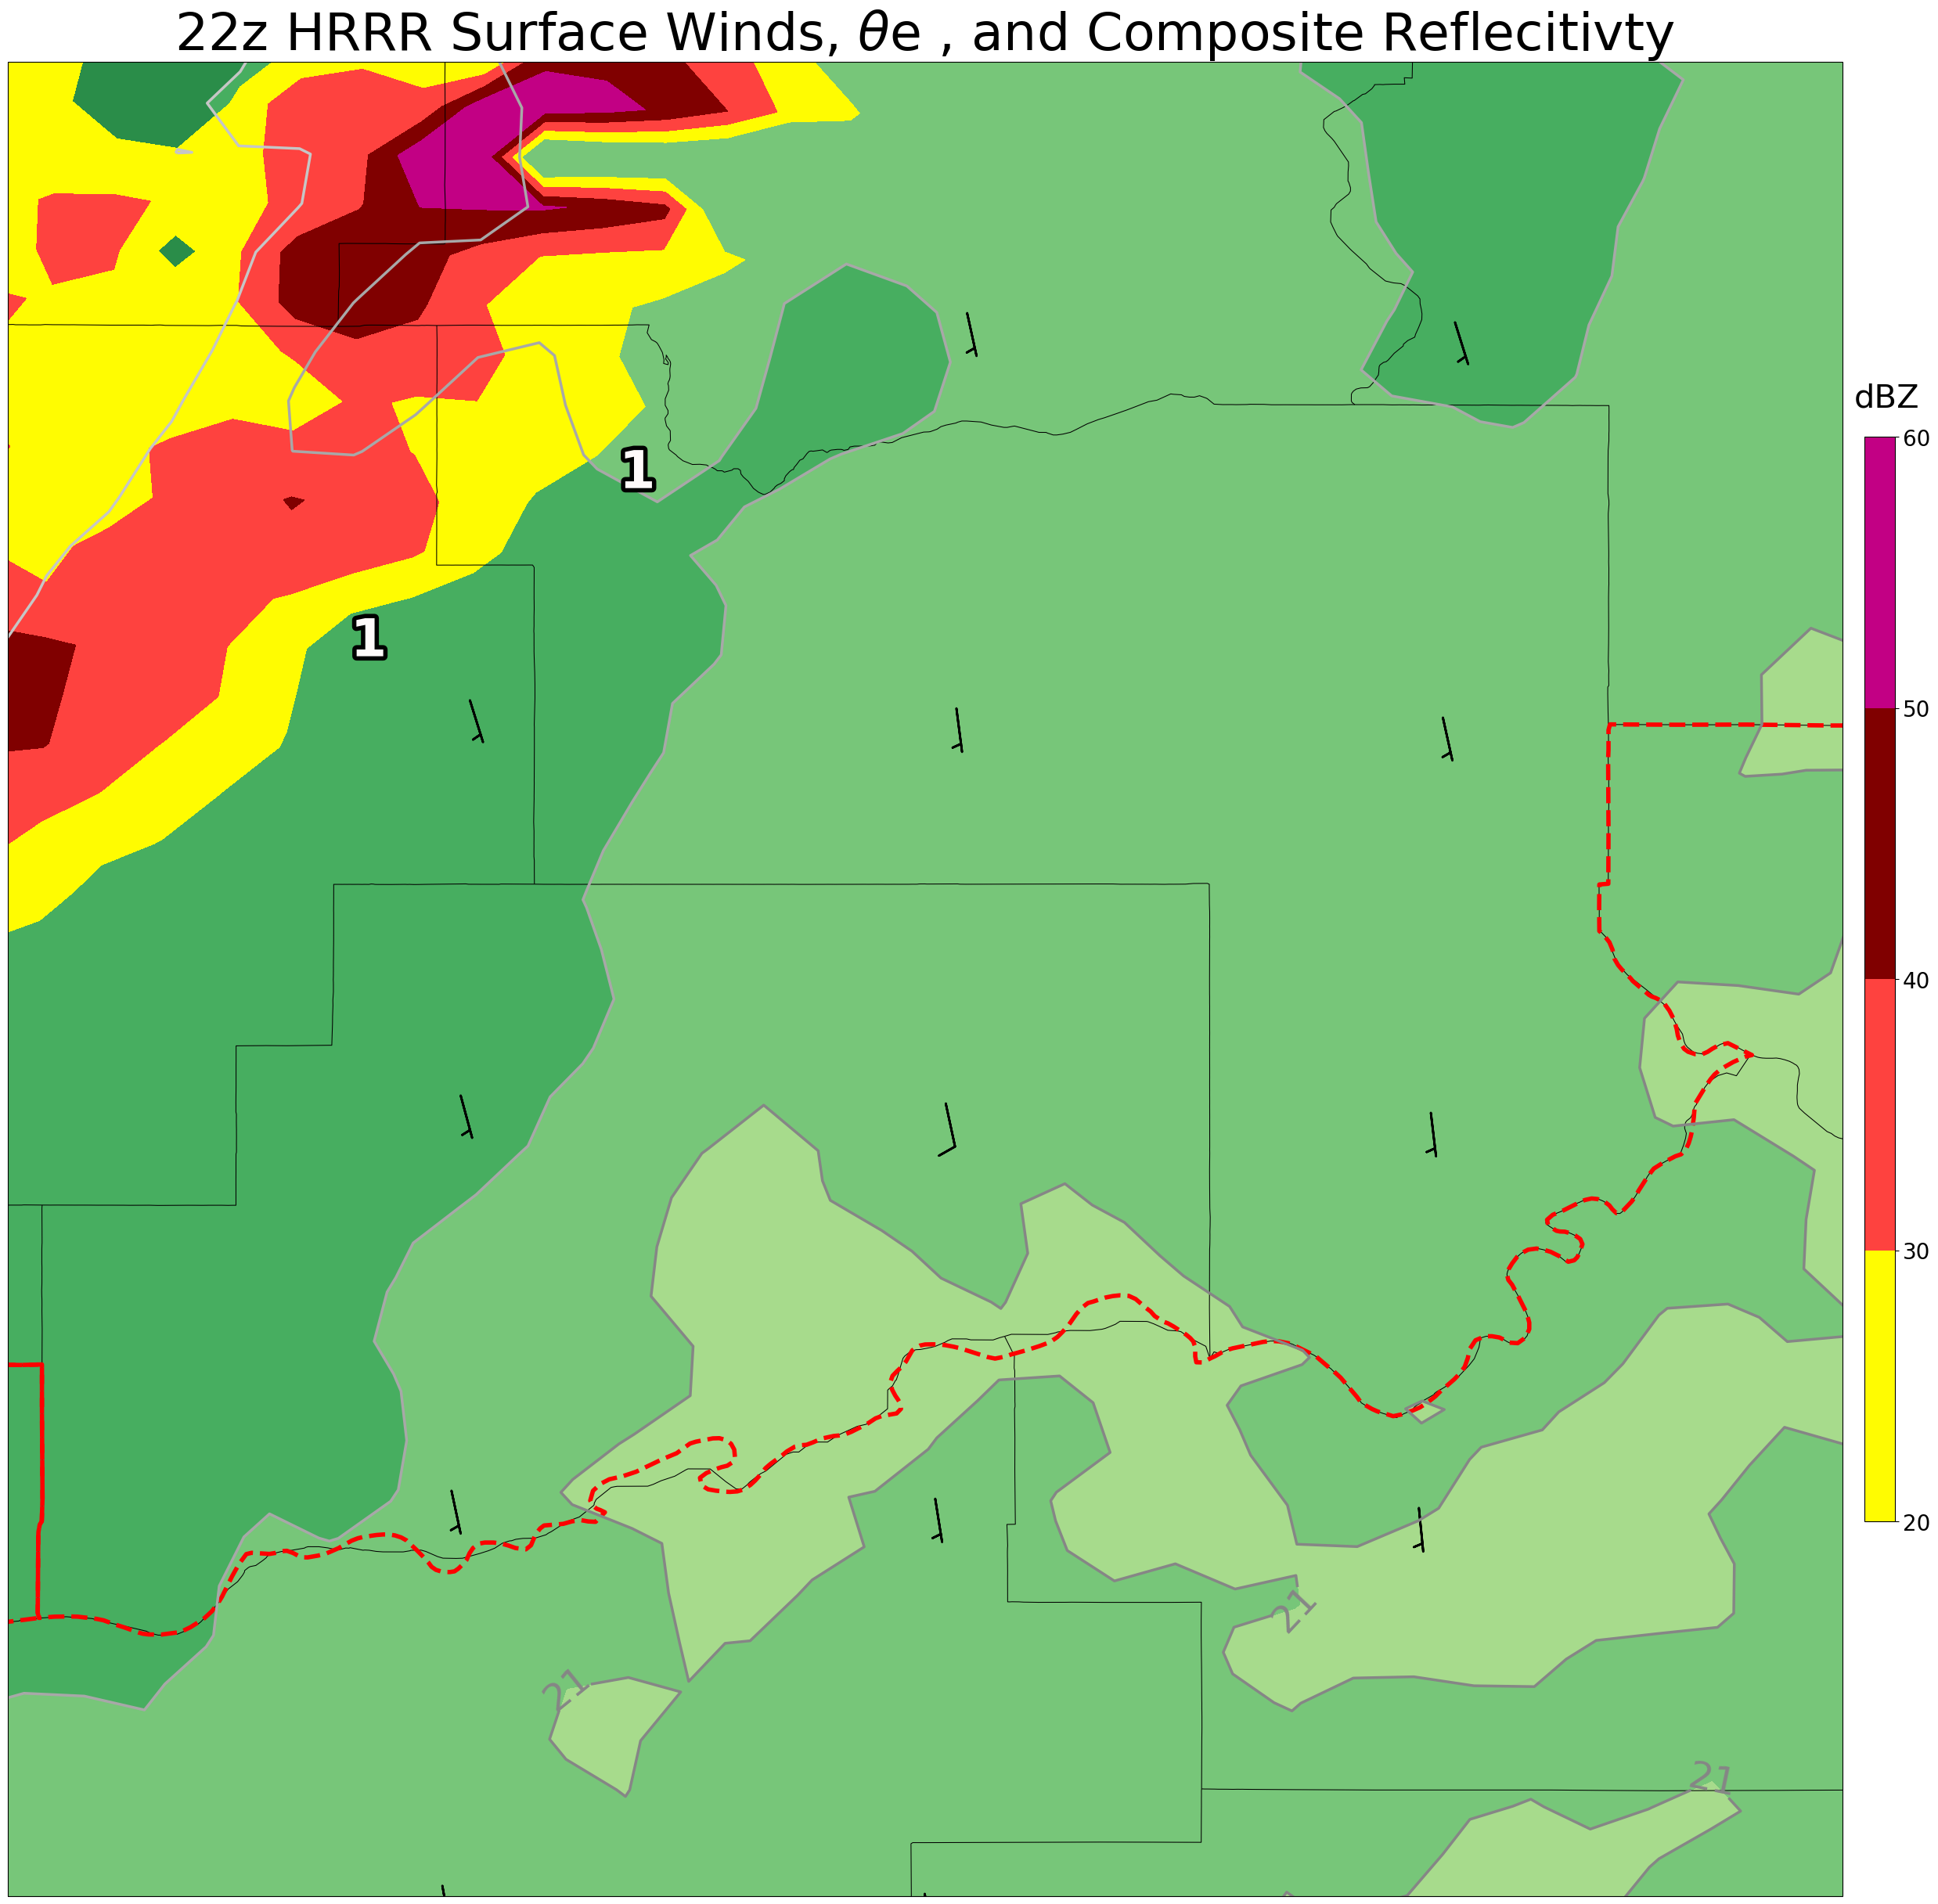

In [30]:
import matplotlib.patheffects as pe

year=2019
month=5
day = 22
hour =22
##############################
run_hour=datetime.datetime(year, month, day, hour)
zarr_ids = [ZarrId(
                run_hour=datetime.datetime(year, month, day, hour) + datetime.timedelta(hours=time_delta),
                level_type="sfc",
                var_level="entire_atmosphere",
                var_name="REFC",
                model_type="anl"
                )
            for time_delta in range(3)] # get 3 hours starting at the given time

dat = load_combined_dataset(zarr_ids)

Hour = hour

time_start = datetime.datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
else:
    hour=str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
else:
    day=str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)
else:
    month=str(month)
year=str(year)

timeIN=str(year+month+day)

fs = s3fs.S3FileSystem(anon=True)
#fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.20190522/conus/')
files = np.array(fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/'))
fileN = np.where(files=='noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/hrrr.t'+hour+'z.wrfnatf00.grib2')
fs.get(files[fileN[0][0]], files[fileN[0][0]].split('/')[-1])
fname=files[fileN[0][0]].split('/')[-1]
c=xr.open_dataset(fname, filter_by_keys={'typeOfLevel': 'hybrid'})
print(fname, "\n")

lev=np.asarray(c.variables['hybrid'][:]) # 0 = lowest level, 49 = highest level
lat=np.asarray(c.variables['latitude'])
lon=((np.asarray(c.variables['longitude'])*-1)+360)*-1

T=np.asarray(c.variables['t'][:]) #K #temperature
q=np.asarray(c.variables['q'][:]) # kg kg**-1 #specific humidity
uwnd=np.asarray(c.variables['u'][:]) #m/s #u wind
vwnd=np.asarray(c.variables['v'][:]) #m/s #v wind
hgt=np.asarray(c.variables['gh'][:]) #geopotential meters #geopotential height
sfc_hgt=np.asarray(c.variables['gh'][0])
VVEL_up=(np.asarray(c.variables['w'][:])) #Pa s**-1 #vertical velocity  
lev=(np.asarray(c.variables['pres'][:])/100.) #hPa #pressure
Td=dewpoint_from_specific_humidity(lev* units('hPa'),T* units('kelvin'),q)
TE = equivalent_potential_temperature(lev* units('hPa'), T* units('kelvin'), Td)

reader = shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\County1010\countyl010g.shp")
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

reader_w= shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\watch_by_county_Y05222000_211\watch_by_county_Y05222000_211.shp")
reader_e= shpreader.Reader(r"C:\Users\kyled\Desktop\UNL MS Thesis\GIS Data\watch_by_county_Y05230000_212\watch_by_county_Y05230000_212.shp")
watch_W = list(reader_w.geometries())
watch_E = list(reader_e.geometries())
watch_W = cfeature.ShapelyFeature(watch_W, ccrs.PlateCarree())
watch_E = cfeature.ShapelyFeature(watch_E, ccrs.PlateCarree())

fig=plt.figure(figsize = (36,36))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-', edgecolor='black', linewidth=1.5)
ax.add_feature(COUNTIES, facecolor='none', edgecolor='black', linewidth=0.75)
ax.add_feature(watch_W, facecolor='none', edgecolor='red', linewidth=4.0, ls='--')
#ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=2.0, ls='--')
ax.add_feature(watch_E, facecolor='none', edgecolor='red', linewidth=4.0, ls='--')
ax.set_extent([-96, -95, 35.0, 36.0])



cmap=plt.get_cmap('YlGn')
#cmap=truncate_colormap(cmap,0.0,1.0)
cmap2=plt.get_cmap('Greys_r')
#cmap2 = truncate_colormap(cmap2, 0.7, 1.0)
cf1 = ax.contourf(lon, lat, Td[0,:,:], range(17,27, 1), cmap=cmap) # Make a filled contour plot
cf1 = ax.contour(lon, lat, Td[0,:,:], range(17,27, 1), cmap=cmap2, linewidths = 2.5)

#pres = ax.contour(lon,lat,lev[0,:,:],range(890,1010,20),cmap='gray',linewidth=10.0)
ax.barbs(x = lon[::8,::8], y = lat[::8,::8], u = uwnd[0][::8,::8], v = vwnd[0][::8,::8], length=9,linewidth=2.0, color='black')



ax.clabel(cf1, inline=1, fontsize=35)


#cbar = plt.colorbar(cf1 , aspect=35, shrink=0.5, pad=0.01)
#cbar = plt.colorbar(cf1, shrink=0.55, pad=0.01)
#cbar.ax.tick_params(labelsize=20)

cmap1 = plt.get_cmap(ctables.REF_pmarsh)
ref_table = truncate_colormap(cmap1, 0.35, 0.75)

#if using model type anl:
cf2 = ax.contourf(dat.REFC[0].longitude, dat.REFC[0].latitude, dat.REFC[0], range(20,70, 10), cmap=ref_table, linewidths=2.5,alpha=1.0) # Make a filled contour plot

#if using model type fcst: 
#cf2 = ax.contour(dat.REFC[0][0].longitude, dat.REFC[0][0].latitude, dat.REFC[0][0], range(20,70, 10), cmap=cmap2, linewidths=3,alpha=1.0) # Make a filled contour plot

cbar2 = plt.colorbar(cf2 , aspect=35, shrink=0.5, pad=0.01)
#cbar = plt.colorbar(cf1, shrink=0.55, pad=0.01)
cbar2.ax.tick_params(labelsize=20)
cbar2.set_label('dBZ', labelpad=-40, y=1.05, rotation=0, fontsize=30)

soundings = pd.read_csv('C:/Users/kyled/Desktop/UNL MS Thesis/2 - QC Near-Inflow Points/Maps/5_22_VerticalProfs_QC_Grouped.csv', usecols=['Time','Grouping', 'Lat', 'Lon','Supercell'])
# xGRP1non = soundings[soundings.Time==Hour][soundings.Grouping=="OPW1"][soundings.Supercell=='N']
# if len(xGRP1non) != 0:
#     for i in range(0,len(xGRP1non)):
#         plt.text(xGRP1non['Lon'].iloc[i],xGRP1non['Lat'].iloc[i],"1",fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])
# xGRP1sup = soundings[soundings.Time==Hour][soundings.Grouping==1][soundings.Supercell=='Y']
# if len(xGRP1sup) != 0:
#     for i in range(0,len(xGRP1sup)):
#         plt.text(xGRP1sup['Lon'].iloc[i],xGRP1sup['Lat'].iloc[i],"1*",fontsize=48,fontweight='bold', color='peachpuff', path_effects=[pe.withStroke(linewidth=8, foreground="black")])      
              
xGRP7non = soundings[soundings.Time==Hour][soundings.Grouping=="OPE1"][soundings.Supercell=='N']
if len(xGRP7non) != 0:
    for i in range(0,len(xGRP7non)):
        plt.text(xGRP7non['Lon'].iloc[i],xGRP7non['Lat'].iloc[i],"1",fontsize=48,fontweight='bold', color='snow',path_effects=[pe.withStroke(linewidth=8, foreground="black")])

plt.title(str(hour)+'z HRRR Surface Winds, 'r'$\theta$e , and Composite Reflecitivty', fontsize=48)
plt.show()
#plt.savefig(r"C:\Users\kyled\Desktop\UNL MS Thesis\2 - QC Near-Inflow Points\Maps\BDY_HRRR2_"+str(hour)+"z.png", bbox_inches='tight')